## Building models with **paintbox**

In **paintbox**, the models used to describe the observed spectrum and/or spectral energy distribution of a galaxy are build from a combination of spectral components, including the stellar continuum, emission lines for the gas, etc. Moreover, the parametrization of the model, i.e., the specific details about how these spectral elements are combined, are defined interactively. Below, we illustrate how to generate these spectral components in practice and how to combine them to make a model.

### Using CvD models

Here we use the CvD single stellar popupation models, and the response functions for several elements, prepared in this [tutorial](https://paintbox.readthedocs.io/en/latest/preparing_models.html#preparing-cvd-models) to illustrate how to  create the basic elements for the stellar continuum.

In [1]:
import os

import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

import paintbox as pb

We first load the data from the CvD models, which are stored in a multi-extension FITS file, and we create an interpolate version of the SSP models.

Parameter names:  ['Z', 'Age', 'x1', 'x2']
Parameters for example:  [0.1 6.  2.3 2.3]


Text(0, 0.5, 'Flux')

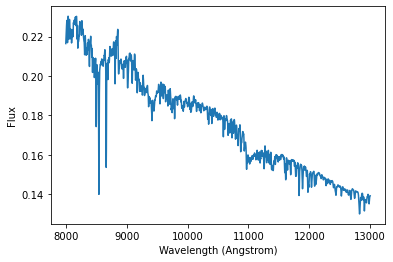

In [2]:
# Reading the content of the FITS file with SSP models
ssp_file = "templates/VCJ17_varydoublex.fits"
templates = fits.getdata(ssp_file, ext=0)
params = Table.read(ssp_file, hdu=1)
wave = Table.read(ssp_file, hdu=2)["wave"].data
# Use paintbox to create a component with interpolated SSP models
ssp = pb.ParametricModel(wave, params, templates)
# Name of the parameters are taken from the input table params
print("Parameter names: ", ssp.parnames)
# Model parameters 
p0 = np.array([0.1, 6, 2.3, 2.3])
print("Parameters for example: ", p0)
fig = plt.subplot(111)
plt.plot(wave, ssp(p0), "-")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")

The SSP models contain elemental abundances that have solar values, but this can be changed with the response functions for each element. In practice, what we have to do is to multiply the response function by the base models generated above. Below we illustrate how to modify the models to the response of sodium, iron, calcium and potassium.

In [3]:
elements = ["Na", "Fe", "Ca", "K"] # 
for element in elements:
    elem_file = "templates/C18_rfs_{}.fits".format(element)
    rfdata = fits.getdata(elem_file, ext=0)
    rfpar = Table.read(elem_file, hdu=1)
    vmin, vmax = rfpar[element].min(), rfpar[element].max()
    rf = pb.ParametricModel(wave, rfpar, rfdata)
    ssp = ssp * rf

In the example above, we are already combining different **paintbox** components, producing one that is a multiplication of a SSP with four different response functions. However, the response functions are also dependent on the ages and metallicities of the SSP models. Consequently, the parameter names get repetitive in this case:

In [4]:
print("Parameter names: ", ssp.parnames)

Parameter names:  ['Z', 'Age', 'x1', 'x2', 'Z', 'Age', 'Na', 'Z', 'Age', 'Fe', 'Z', 'Age', 'Ca', 'Z', 'Age', 'K']


By default, **paintbox** just concatenate all the parameter names. However, in this application, we should use the same ages and metallicities in the model, which can be obtained by constraining the model as indicated below.

In [6]:
ssp = pb.Constrain(ssp)
print(ssp.parnames)

['Z', 'Age', 'x1', 'x2', 'Na', 'Fe', 'Ca', 'K']


The ConstrainModel operator allows consistent calls to all parameters that are repeated. 

Parameters for non-solar abundances:  [0.1  6.   2.3  2.3  0.05 0.05 0.05 0.05]


Text(0, 0.5, 'Flux')

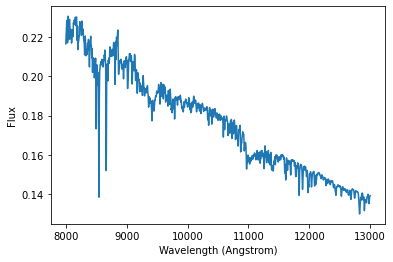

In [7]:
# Model parameters 
p1 = np.array([0.1, 6, 2.3, 2.3, 0.05, 0.05, 0.05, 0.05])
print("Parameters for non-solar abundances: ", p1)
fig = plt.subplot(111)
plt.plot(wave, ssp(p1), "-")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")

In [9]:
tab = Table([wave, ssp(p1)], names=["wave", "flux"])
tab.write("test_CvD_2.fits", overwrite=True)


### Emission lines

TBD.

### Continuum elements: polynomials and extinction laws

### Line-of-sight velocity distribution

### Rebinning